In [1]:
# increase cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

## TODO:

1. Data: 
    - **done** create script to combine all congresses
    - **done** create a party and chamber lists for addtional support
    - **done** create congress number list

2. Train/Val/Test split:
    -  **done** Put into a separate module
    -  **done** Add an option to select a party or chapter
    - **memory error** Split train/val/test by congress to avoid time bias
    - Play with hyperparameters:
        - word_count
        - random_splits: allocate more to training?
        - increase balance ratio?

3. EDA:
    - Targets by party: should we run gender/ethnicity on Ds only?

4. Vectorization:
    - Tune hyper parameters:
        - ngram_range: 1, 3
        - change vocabulary size
    - Add outputs:
        - **done** stop words
        - **done** lowest scoring words
        - **done** top n 5 by congress

5. Ngram model:
    - Tune hyper parameters:
        - use GridSearch?
        - activation function
        - learning rate
        - batch size
        - layers
        - units
        - dropout rate
        - any other regularization (there is significant overfit)
    - Run model:
        - for each congress
        - add one congress at a time
           - hypothesis: is accuracy improving due to more data or more diversity?
        - run only for Ds?
    - Outputs:
        - **done** how to output predicted probablity?
    - Model validation:
        - **done** build a separate function so it can be used with different models:
            - **done** input: predicted probability; actual labels; data (val or test?)
        - **done** chart distribution of the predicted probability 
        - **done** bin predicted probabilities into:
            - **done** 0:0.4, 0.4:0.6, 0.6:1?
            - **done** accuracy in each bin
            - **done** crosstab them with various demos (party, chamber, age, year)
            - **done** get 1,2,3-grams for each bin
        - **done** output examples of speeches with scores close to 1 and close to 0 that are mispredicted vs predicted correctly
        - Accuracy/loss by congress
        - Accuracy/loss as congresses added
            - save them and plot them

### Long term:

1. classificaiton models:
    - ngram vanilla NN
    - CNN
    - sentence embeddings
    - some other models
    - does it help to combine the results ensemble? if they make different mistakes, it should.
2. Create a topics model:
    - on raw data before classification
    - on groups based on predicted probability bings:
       - can we explain classification by topics that they bring up?
       - or is it just based on language used? here we would check 1,2,3-ngrams
3. Age:
    - aging congress: how does it affect topics that people bring up?
4. Speaker-level analysis:
    - cluster speakers (k-means?) by their average predicted scores in classification models?
        - for example, a white male that is closer to women by the way they use speech? are they liberals?

Inspiration for code:

- https://developers.google.com/machine-learning/guides/text-classification/
- https://github.com/google/eng-edu/blob/master/ml/guides/text_classification/load_data.py

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import os
import random
import time
import pickle

import numpy as np
import pandas as pd

from importlib import reload

import scipy.sparse

In [6]:
from helpers import load_data
from helpers import explore_data
from helpers import preprocess_data
from helpers import train_model

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## Load the data

In [7]:
pwd

'/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification'

In [13]:
!head -2 ../../FinalProject/hein-daily/speeches_097.txt

speech_id|speech
970000001|The Senate vill please come to order. The Chaplain will offer the prayer. The Chaplain. the Reverend Edward L. R. Elson. D.D.. offered the following prayer: PRAYER God of our fathers and our God. who has made and preserved us a nation. we thank Thee for Thy care over us from generation to generation. and for the new era which unfolds before us. Let Thy spirit descend upon us with all Its cleansing. healing. and creative power. Make usnew persons for new times in a land newborn in spirit. May the solemn induction of the new Members of this body be a renewal of the vocatinal vows of all others. In the deliberations of this new Congress keep our motives pure. our vision clear. our patriotism undefiled. our speech chaste. our judgments fair. and our consciences unbetrayed. Help us to develop work patterns which sustain the soul. nourish the mind. and strengthen the will. And give us grace to make time for the family. for home. and for worship. What we pray for th

In [14]:
!cat ../../FinalProject/hein-daily/speeches_097.txt | wc -l

  283399


In [20]:
data_path = '../../FinalProject/hein-daily/Sample'

In [21]:
reload(load_data)
all_speech_ids, all_speeches = load_data.load_speech_data(data_path)


File speeches_097.txt has 249718612 characters
and 283399 speeches

Speeches list has 283399 speeches


In [22]:
len(all_speech_ids), len(all_speeches)

(283399, 283399)

## Create target labels

#### TODO:

- Why is this taking so much time?
- Subset on word cound here?
- Make sampling replicable: random seed + random array of proper length

In [24]:
reload(load_data)
start_time = time.time()
# remove p if want to run for the full speech file
descr = load_data.load_descr_data('../data/QA/full_descr.txt', p=0.3)
print("\nIt took {0:.1f} seconds to create the dictionary".format(time.time()-start_time))

2914465 lines have been read
7227 keys had duplicates and deleted
The dictionary has 858639 keys

Random congressperson: 970167231
date 19820513
char_count 164
word_count 33
speakerid 97104811.0
Party R
Congress 97
Chamber S
State TN
Ethnicity W
Age 57.0
Age_lt_med 0.0
NonWhite 0.0
Female 0.0
speaker Mr. BAKER
Full Name BAKER, HOWARD
match exact
check 1

It took 6.9 seconds to create the dictionary


In [25]:
# check if sampling worked
len(list(descr.keys()))/2914464

0.29461300602786655

In [26]:
gender, ethnicity, age, party, chamber, congress = load_data.create_target_labels(all_speech_ids, descr)
len(gender), len(ethnicity), len(age), len(party), len(chamber), len(congress)

(283399, 283399, 283399, 283399, 283399, 283399)

### Data QA

In [27]:
reload(explore_data)
for i in [(gender, "Gender"), (ethnicity, "Ethnicity"), (age, "Age")]:
    print("\n", i[1])
    print("Overall speech counts:")
    explore_data.get_counts(i[0])
    print("Target group number of speeches by party:")
    explore_data.get_counts_by_category(i[0], party)


 Gender
Overall speech counts:


,Category,Count
0,-1,216551
1,0,65477
2,1,1371


Target group number of speeches by party:
D: 	 664
I: 	 0
N: 	 0
NA: 	 -216551
R: 	 707

 Ethnicity
Overall speech counts:


,Category,Count
0,-1,216551
1,0,64037
2,1,2811


Target group number of speeches by party:
D: 	 2405
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 361

 Age
Overall speech counts:


,Category,Count
0,-1,216551
1,0,43720
2,1,23128


Target group number of speeches by party:
D: 	 12400
I: 	 0
N: 	 45
NA: 	 -216551
R: 	 10683


In [28]:
reload(explore_data)
explore_data.random_speech(all_speeches, all_speech_ids, gender, descr)

Speaker information
date 19810616
char_count 1326
word_count 250
speakerid 97111540.0
Party D
Congress 97
Chamber H
State CO
Ethnicity W
Age 42.0
Age_lt_med 1.0
NonWhite 0.0
Female 1.0
speaker Mrs. SCHROEDER
Full Name SCHROEDER, PATRICIA
match exact
check 1

Mr. Speaker. I hate to say this. but ever since I got here. I have been waiting for a motherhood issue. This Is it. I can not imagine any mother voting any way but for the resolution. I was very. very. very surprised by the administrations action on infant formula. I commend the committee for reporting this resolution because I think it is very important that the legislative body go on record as saying to tihe world that we think the administration made a mistake. I think it will send a special signal to the world right now because this body is tending to want to act like the administrations rowing team on every issue and if we are willing to stand tip and say on this issue we think they made a mistake. we have the courage to say i

In [12]:
explore_data.random_speech(all_speeches, all_speech_ids, ethnicity, descr)

Speaker information
speakerid 97108270.0
word_count 435
State NY
Age 49.0
Full Name GARCIA, ROBERT
Congress 97
Party D
match exact
date 19820729
Female 0.0
char_count 2518
Ethnicity H
Age_lt_med 1.0
Chamber H
NonWhite 1.0
speaker Mr. GARCIA

Mr. Chairman. I believe the amendment is particularly appropriate at this moment. because we are toward the end of this bill. We have been at it for almost 40 hours. if not 40 hours. I think that there have been some discussions held here as it pertained to what exactly is in this package. At the same time. Mr. Speaker. that we are presently cutting care to the elderly and to the poor. the Federal Government is paying for the veterinary care of pets for military personnel. At the same time. Mr. Speaker. that we cut money for food stamps and lunches for schoolchildren. the taxpayers are paying for meals served in the Secretary of Defense. Casper Weinbergers private dining.room. At the same time that we cut education aid denying young men and women t

In [29]:
explore_data.random_speech(all_speeches, all_speech_ids, age, descr)

Speaker information
date 19810708
char_count 191
word_count 34
speakerid 97109130.0
Party D
Congress 97
Chamber H
State GA
Ethnicity W
Age 43.0
Age_lt_med 1.0
NonWhite 0.0
Female 0.0
speaker Mr. HATCHER
Full Name HATCHER, CHARLES
match fuzzy
check 1

Mr. Speaker. I move that the House do now adjourn. Themotion was agreed to. accordIngly (at 6 oclock and 2 minutes p.m.) the House adjourned until tomorrow. Thursday. July 9. 1981. at 10 a.m.


## Split into train, validate, test

### Filter on party if necessary

In [28]:
# reload(load_data)
# all_speeches_d, all_speech_ids_d, gender_d = load_data.filter_data(all_speeches, all_speech_ids, gender, party, 'D')
# len(all_speeches_d), len(all_speech_ids_d), len(gender_d)

In [37]:
# reload(explore_data)
# explore_data.get_counts(gender_d)

,Category,Count
0,0,103864
1,1,2172


### Split into train/val/test

### Split by congress

In [9]:
# reload(preprocess_data)
# train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_by_congress(all_speeches, all_speech_ids, gender, descr, congress)

In [30]:
reload(preprocess_data)
train, train_ids, train_target, val, val_ids, val_target, test, test_ids, test_target = preprocess_data.split_train_val_test(all_speeches, all_speech_ids, gender, descr)

Training split: 501 ones and 501 zeroes
Training speech list size: 1002
Training target list size: 1002
Validation split: 167 ones and 167 zeroes
Validation speech list size: 334
Validation target list size: 334
Test split: 167 ones and 167 zeroes
Test speech list size: 334
Test target list size: 334


In [32]:
sum(train_target), sum(val_target), sum(test_target)

(501, 167, 167)

In [33]:
# number of speeches under 30 words
sum(np.array(gender)==1) - (sum(train_target) + sum(val_target) + sum(test_target))

536

In [34]:
explore_data.random_speech(train, train_ids, train_target, descr)

Speaker information
date 19820429
char_count 1948
word_count 328
speakerid 97120530.0
Party D
Congress 97
Chamber H
State MD
Ethnicity W
Age 46.0
Age_lt_med 1.0
NonWhite 0.0
Female 1.0
speaker Ms. MIKULSKI
Full Name MIKULSKI, BARBARA
match fuzzy
check 1

Mr. Speaker. I am today introducing a joint resolution which urges all Americans to pause at 4 p.m.. e.d.t. on June 14 to say the Pledge of Allegiance to the flag as part of the National Flag Day celebiation. This idea. the "Pause for the Pledge." is the dream of k group of dedicated volunteers from the StarSpangled Banner Flag House In Baltimore. and I share that dream. The StarSpangled Banner Flag Hcuse Association in Baltimore has c een the official sponsor of the NaLional Flag Week festivities since 1952. Their headquarters is the house where Mary Young Pickersgill sewed the flag E 1958 April 29. 1982 CONGRI that flew over Fort McHenry in 1814 and inspired Francis Scott Key to write the national anthem. This project.- this dream. i

## EDA on train data

Source: https://developers.google.com/machine-learning/guides/text-classification/step-2

### Check median number of words per sample in train/val/test

In [35]:
reload(explore_data)

<module 'helpers.explore_data' from '/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification/helpers/explore_data.py'>

In [36]:
explore_data.get_num_words_per_sample(train)

211.0

In [37]:
explore_data.get_num_words_per_sample(val)

263.5

In [38]:
explore_data.get_num_words_per_sample(test)

206.5

Speech length percentiles
    0     10    20     30     40     50     60     70     80     90      100
0  31.0  46.0  81.2  114.3  158.0  211.0  269.6  350.4  493.6  792.9  3314.0


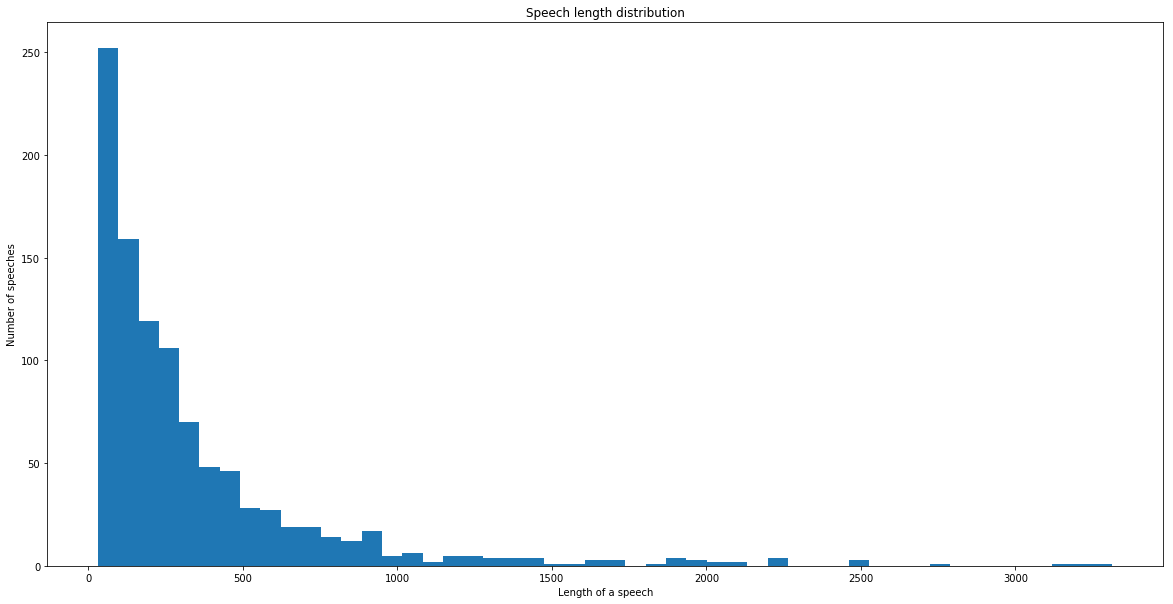

In [39]:
reload(explore_data)
explore_data.plot_sample_length_distribution(train)

### Most popular unigrams (training only)

In [40]:
train_sample = random.sample(train, int(len(train)*0.2))
len(train_sample)

200

['the', 'of', 'to', 'and', 'in', 'that', 'is', 'for', 'this', 'it', 'be', 'we', 'on', 'have', 'by', 'not', 'are', 'as', 'with', 'would', 'has', 'our', 'will', 'was', 'mr', 'from', 'at', 'an', 'which', 'they', 'president', 'my', 'but', 'he', 'been', 'or', 'their', 'who', 'all', 'committee', 'his', 'do', 'new', 'can', 'there', 'more', 'people', 'if', 'bill', 'time']


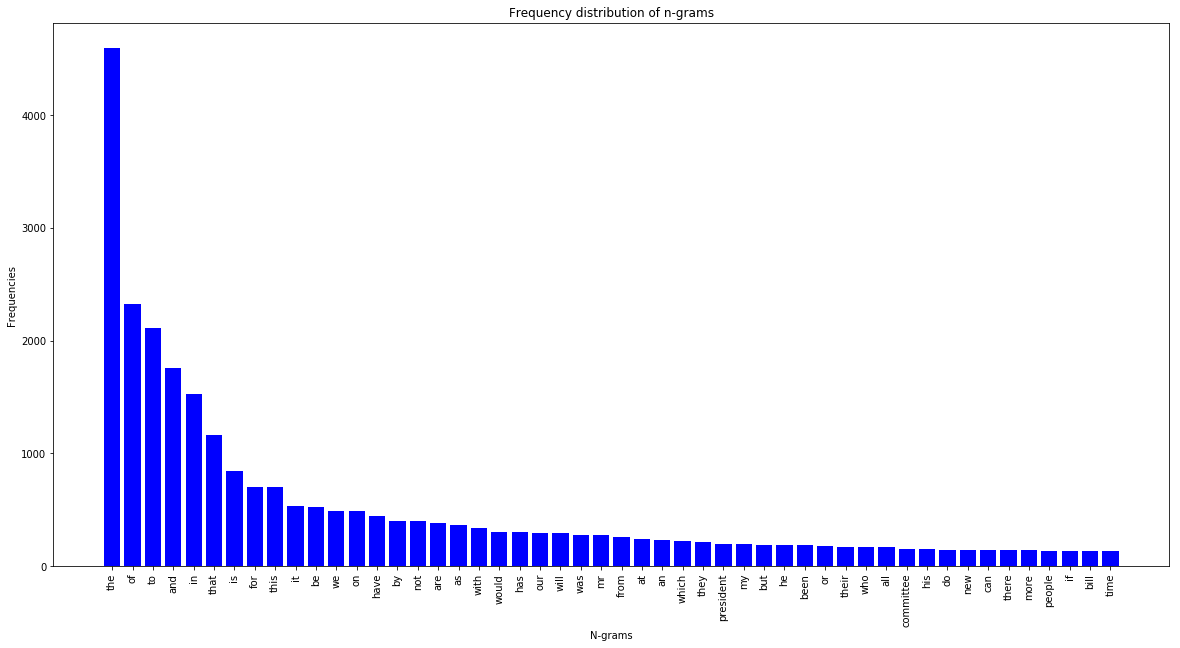

In [41]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(1,1))

### Most popular bigrams (training only)

['of the', 'in the', 'to the', 'it is', 'for the', 'that the', 'and the', 'on the', 'by the', 'to be', 'mr president', 'of this', 'will be', 'with the', 'mr speaker', 'we have', 'the united', 'that is', 'has been', 'at the', 'have been', 'we are', 'united states', 'the committee', 'would be', 'there is', 'that we', 'from the', 'the senate', 'do not', 'like to', 'in this', 'is the', 'is not', 'of our', 'the house', 'one of', 'would like', 'social security', 'mr chairman', 'this is', 'the senator', 'my colleagues', 'as the', 'the president', 'the federal', 'this bill', 'this amendment', 'the gentleman', 'and to']


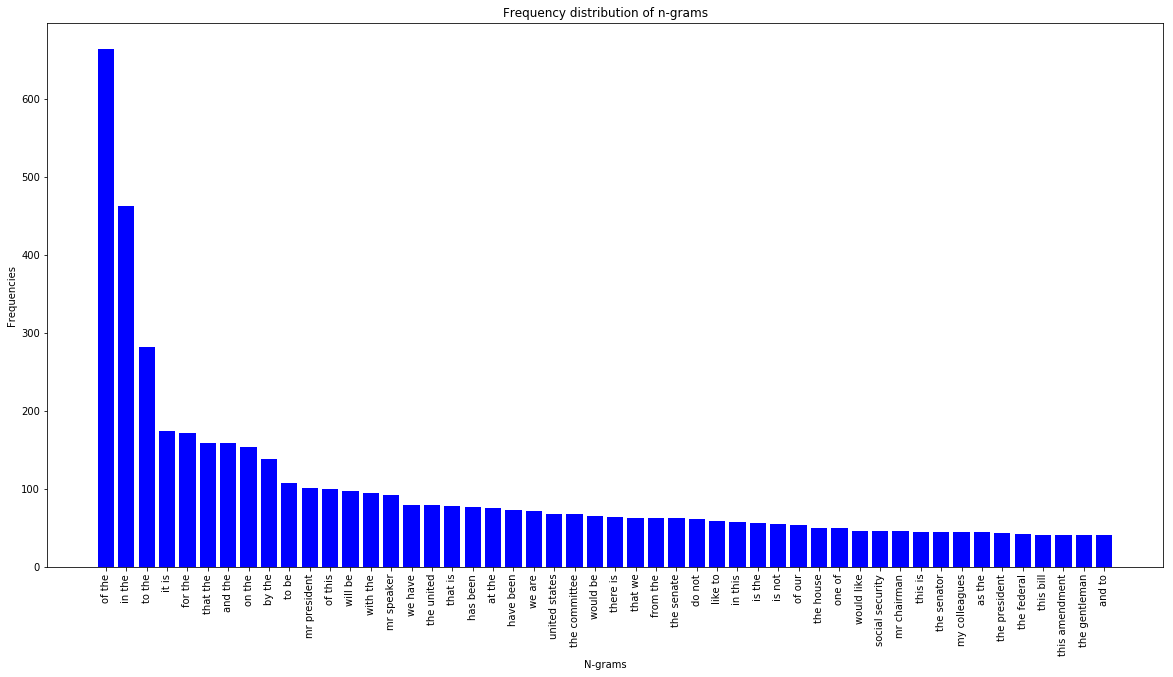

In [42]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(2,2))

### Most popular trigrams (training only)

['the united states', 'would like to', 'one of the', 'the senator from', 'the fact that', 'the gentleman from', 'of the committee', 'in support of', 'the committee on', 'ask unanimous consent', 'out of the', 'part of the', 'the social security', 'the american people', 'support of the', 'of the united', 'it is not', 'in the record', 'there is no', 'it would be', 'chairman of the', 'the people of', 'the members of', 'members of the', 'in the united', 'we do not', 'unanimous consent that', 'the soviet union', 'rise in support', 'the federal government', 'mr president ask', 'it has been', 'in order to', 'think it is', 'the same time', 'the development of', 'social security system', 'printed in the', 'of the senate', 'of the national', 'member of the', 'is going to', 'be able to', 'at the same', 'the chairman of', 'that we are', 'that it is', 'that has been', 'president of the', 'president ask unanimous']


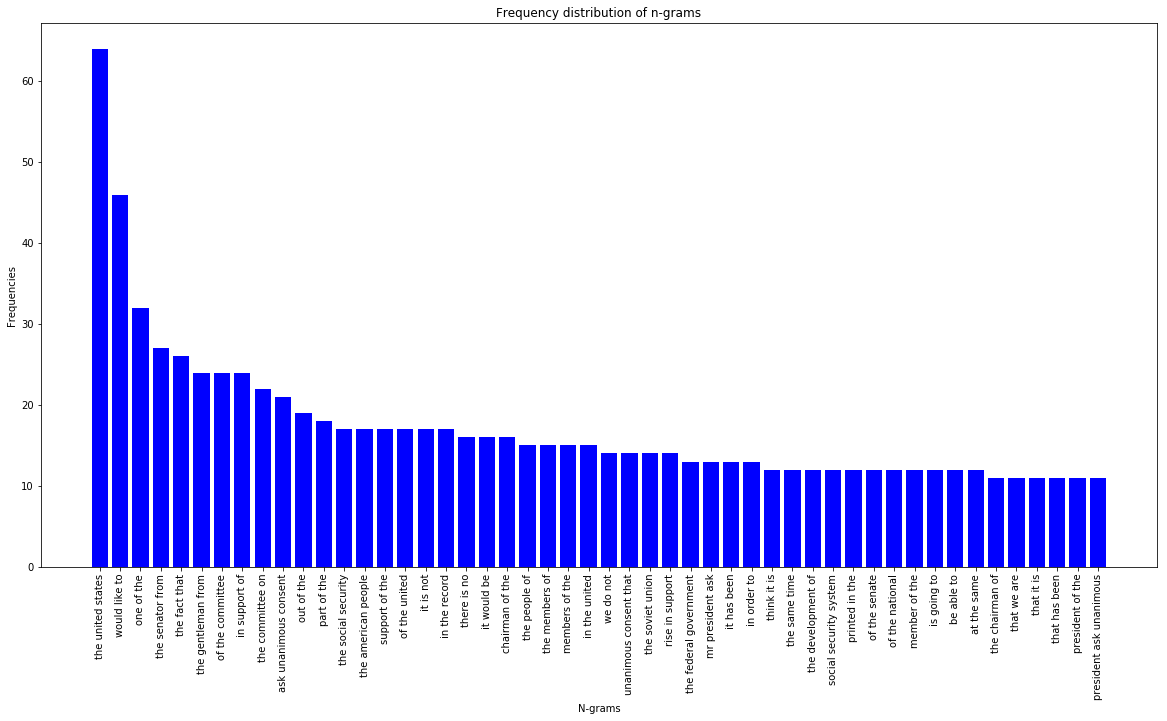

In [43]:
explore_data.plot_frequency_distribution_of_ngrams(train_sample, ngram_range=(3,3))

In [44]:
congress = set([str(i) for i in range(97,115)])

In [45]:
len(train)

1002

In [46]:
descr['1110063404']

{'date': '20090930',
 'char_count': '1356',
 'word_count': '244',
 'speakerid': '111118281.0',
 'Party': 'R',
 'Congress': '111',
 'Chamber': 'S',
 'State': 'TN',
 'Ethnicity': 'W',
 'Age': '70.0',
 'Age_lt_med': '0.0',
 'NonWhite': '0.0',
 'Female': '0.0',
 'speaker': 'Mr. ALEXANDER',
 'Full Name': 'ALEXANDER, LAMAR',
 'match': 'exact',
 'check': 1}

In [47]:
reload(explore_data)
explore_data.ngrams_by_category(train, train_ids, descr, congress, 'Congress', p=0.3, top_n=5)


For Congress 97 top 5 (3, 3) ngrams are:
the united states
would like to
the gentleman from
one of the
of the united
--------------------


## N-gram model

Inspiration for code: https://developers.google.com/machine-learning/guides/text-classification/step-3

### Pre-processing

In [48]:
# Vectorization parameters
# Range (inclusive) of n-gram sizes for tokenizing text.
NGRAM_RANGE = (1, 2)

# Minimum corpus frequency below which a token will be discarded.
MIN_DOCUMENT_FREQUENCY = 5

# Maximum proportion of corpus containing a word above which a token will be discarded.
# Helps eliminate stop words
MAX_DOCUMENT_FREQUENCY = 0.7

# Limit on the number of features. We use the top 20K features.
TOP_K = 20000

# Output number of top/bottom scoring ngrams
TOP_N = 5

vec_params = {
    'ngram_range': NGRAM_RANGE,
    'min_df': MIN_DOCUMENT_FREQUENCY,
    'max_df': MAX_DOCUMENT_FREQUENCY,
    'top_k': TOP_K,
    'top_n': TOP_N
}

In [49]:
reload(preprocess_data)
train_vec, val_vec, test_vec = preprocess_data.ngram_vectorize(train, train_target, val, test, **vec_params)

Total vocabulary size: 12469
Number of stop words 157763

Top 5 ngrams by differentiating score:
mr president 	 92.2
president 	 55.9
senator 	 49.6
distinguished 	 35.9
the senator 	 33.8

Bottom 5 ngrams by differentiating score:
treaty 	 0.0
well as 	 0.0
president was 	 0.0
of foreign 	 0.0
levels for 	 0.0


In [50]:
len(train), len(val), len(test)

(1002, 334, 334)

In [51]:
train_vec.shape, val_vec.shape, test_vec.shape

((1002, 12469), (334, 12469), (334, 12469))

### Saving processed files

In [52]:
pwd

'/Users/fariamardhani/Berkeley/W266/W266-Final-Project/Classification'

In [53]:
data_path = '../../FinalProject/saved_files'

In [54]:
scipy.sparse.save_npz(os.path.join(data_path, 'train_vec.npz'), train_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'val_vec.npz'), val_vec)
scipy.sparse.save_npz(os.path.join(data_path, 'test_vec.npz'), test_vec)

In [55]:
train_vec = scipy.sparse.load_npz(os.path.join(data_path, 'train_vec.npz'))
val_vec = scipy.sparse.load_npz(os.path.join(data_path, 'val_vec.npz'))
test_vec = scipy.sparse.load_npz(os.path.join(data_path, 'test_vec.npz'))

In [56]:
train_vec.shape, val_vec.shape, test_vec.shape

((1002, 12469), (334, 12469), (334, 12469))

In [57]:
with open(os.path.join(data_path, 'train_list'), 'wb') as fp:
    pickle.dump(train, fp)
with open(os.path.join(data_path, 'train_ids'), 'wb') as fp:
    pickle.dump(train_ids, fp)
with open(os.path.join(data_path, 'train_target'), 'wb') as fp:
    pickle.dump(train_target, fp)
with open(os.path.join(data_path, 'val_list'), 'wb') as fp:
    pickle.dump(val, fp)
with open(os.path.join(data_path, 'val_ids'), 'wb') as fp:
    pickle.dump(val_ids, fp)
with open(os.path.join(data_path, 'val_target'), 'wb') as fp:
    pickle.dump(val_target, fp)
with open(os.path.join(data_path, 'test_list'), 'wb') as fp:
    pickle.dump(test, fp)
with open(os.path.join(data_path, 'test_ids'), 'wb') as fp:
    pickle.dump(test_ids, fp)
with open(os.path.join(data_path, 'test_target'), 'wb') as fp:
    pickle.dump(test_target, fp)

In [58]:
sum(train_target), sum(val_target), sum(test_target)

(501, 167, 167)

In [59]:
with open(os.path.join(data_path, 'train_list'), 'rb') as fp:
    train = pickle.load(fp)
with open(os.path.join(data_path, 'train_ids'), 'rb') as fp:
    train_ids = pickle.load(fp)
with open(os.path.join(data_path, 'train_target'), 'rb') as fp:
    train_target = pickle.load(fp)
with open(os.path.join(data_path, 'val_list'), 'rb') as fp:
    val = pickle.load(fp)
with open(os.path.join(data_path, 'val_ids'), 'rb') as fp:
    val_ids = pickle.load(fp)
with open(os.path.join(data_path, 'val_target'), 'rb') as fp:
    val_target = pickle.load(fp)
with open(os.path.join(data_path, 'test_list'), 'rb') as fp:
    test = pickle.load(fp)
with open(os.path.join(data_path, 'test_ids'), 'rb') as fp:
    test_ids = pickle.load(fp)
with open(os.path.join(data_path, 'test_target'), 'rb') as fp:
    test_target = pickle.load(fp)

In [60]:
sum(train_target), sum(val_target), sum(test_target)

(501, 167, 167)

### Model: Multi-Layer Perceptron (Vanilla NN)

In [61]:
logs_base_dir = '../../FinalProject/logs'

In [62]:
model_params = {
    'learning_rate': 1e-3,
    'epochs': 1000,
    'batch_size': 128,
    'layers': 2,
    'units': 64,
    'dropout_rate': 0.2
}

In [66]:
reload(train_model)
history, train_pred_probs, val_pred_probs = train_model.train_model(((train_vec, train_target), (val_vec, val_target)), log_dir=logs_base_dir, model='ngram', **model_params)

TypeError: train_model() missing 1 required positional argument: 'word_index'

## Model evaluation

In [42]:
val_preds = val_pred_probs > 0.5
np.sum(val_preds.flatten()==val_target)

243

Confusion matrix, without normalization
[[121  46]
 [ 45 122]]


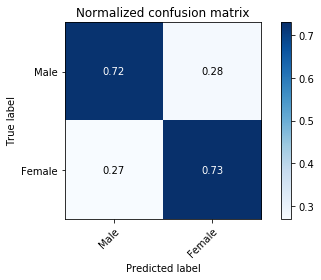

In [43]:
reload(explore_data)
# specify class names in 0 - 1 order
classes = ['Male', 'Female']
explore_data.plot_confusion_matrix(val_target, val_preds, classes, normalize=True)

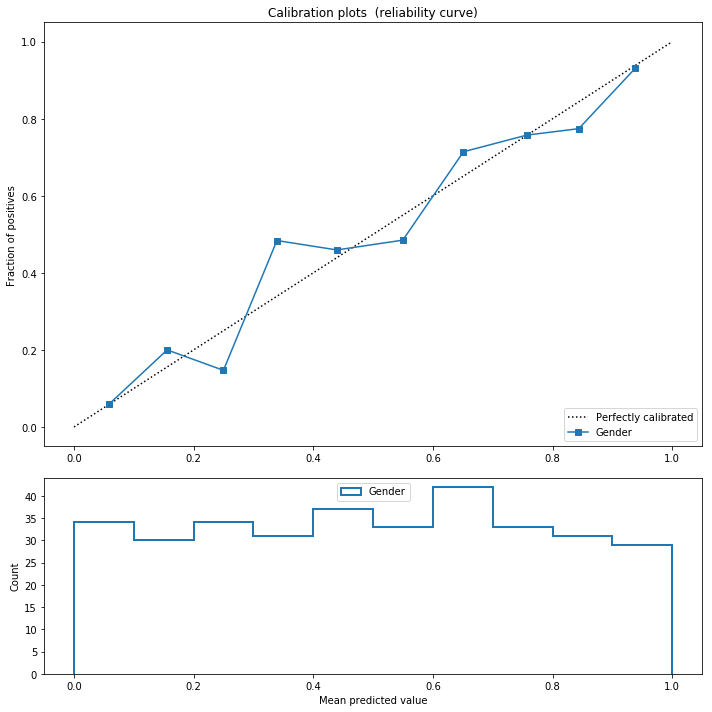

In [44]:
reload(explore_data)
explore_data.plot_calibration_curve(val_target, val_pred_probs, 'Gender')

In [45]:
val_random = np.random.choice(a=[0,1], size=len(val_target), p = [0.7,0.3])
val_random.sum()/val_random.shape[0]

0.2874251497005988

In [49]:
val_sample, val_ids_sample, val_pred_probs_sample = [], [], []
for i in range(len(val_ids)):
    if val_random[i] == 1:
        val_sample.append(val[i])
        val_ids_sample.append(val_ids[i])
        val_pred_probs_sample.append(val_pred_probs[i])
len(val_sample), len(val_ids_sample), len(val_pred_probs_sample)

(96, 96, 96)

In [ ]:
descr_df = pd.read_csv('../data/QA/full_descr.txt', sep="|", index_col=0)
descr_df.shape

In [61]:
reload(explore_data)
explore_data.check_bin_probs_distr(val_pred_probs, val_ids, descr_df)

Finished building main df


,Gender_F,Ethinicity_NW,AvgAge,Party_D,Chamber_H,AvgWordCount
0.4,0.31,0.00,1.07,0.83,0.66,0.98
0.6,0.83,0.00,0.95,0.90,0.98,1.06
1.0,1.70,2.46,0.97,1.21,1.30,0.99


In [59]:
reload(explore_data)
explore_data.compare_ngrams(val, val_pred_probs)


Top 10 ngrams by differentiating score:
ask unanimous consent that 	 17.1
unanimous consent that 	 17.1
ask unanimous consent 	 14.0
the senator from 	 11.9
in support of 	 9.4
subcommittee on civil service 	 7.9
on civil service 	 7.9
and to make 	 7.9
consent that the 	 7.6
unanimous consent that the 	 7.6


,0.4,0.6,1.0
and to make,0.0,4.0,0.0
ask unanimous consent,25.0,3.0,0.0
ask unanimous consent that,22.0,0.0,0.0
consent that the,9.0,0.0,0.0
in support of,2.0,6.0,25.0
on civil service,0.0,4.0,0.0
subcommittee on civil service,0.0,4.0,0.0
the senator from,37.0,0.0,0.0
unanimous consent that,22.0,0.0,0.0
unanimous consent that the,9.0,0.0,0.0


In [58]:
reload(explore_data)
explore_data.ngrams_by_bin(val_sample, val_pred_probs_sample)


In 0.4 bin top 10 ngrams:

the united states
the gentleman from
of the united states
of the united
the department of
unanimous consent that
this is the
of the island
fairfax symphony orchestra
ask unanimous consent that
--------------------

In 0.6 bin top 10 ngrams:

the federal government
the united states
the secretary of
the estate tax
the washington post
the dairy support program
the dairy support
for the federal
dairy support program
aware of the
--------------------

In 1.0 bin top 10 ngrams:

the united states
percent of the
would like to
out of the
we should not
the obey substitute
the number of
the federal government
thank the gentleman
one of the
--------------------


In [60]:
reload(explore_data)
explore_data.print_mispredictions(val_target, val_pred_probs, val, val_ids, descr)


True positive (Predicted prob: 0.91):

char_count 1473
speaker Mrs. ROUKEMA
Chamber H
Party R
match exact
Ethnicity W
Full Name ROUKEMA, MARGE
Age 53.0
Age_lt_med 0.0
date 19820921
State NJ
word_count 226
NonWhite 0.0
check 1
Female 1.0
Congress 97
speakerid 97113260.0

 Mr. Chairman. today I reluctantly rise in opposition to this legislation. Reluctantly because this bill contains appropriations for a number of programs which are important to my own State. as well as appropriations for transportation programs important to our country as a whole. It is unfortunate that the committee has chosen to jeopardize the funding of these vital programs by neglecting to report out a bill that represents true spending requirements. First. due to recently passed increased aviation taxes. supplemental amounts totaling $323 million will be required for FAA. facilities and equipment. and research engineering and development. Second. the committee bill does not include $61 million that will be require